In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix

In this notebook we'll implement Markov Chain Monte Carlo (MCMC) to generate samples from an arbitrary, unnormalized distribution.

In [65]:
np.random.seed(109)
cov1 = make_spd_matrix(2)*2
cov2 = make_spd_matrix(2)
def posterior(theta, cov1=cov1, cov2=cov2):
    return np.abs(9*multivariate_normal(mean=(1,3), cov=cov1).pdf(theta)*np.sin(theta.T[1]) +\
           2*multivariate_normal(mean=(-1,-1), cov=cov2).pdf(theta)*np.sin(2*theta.T[0]))

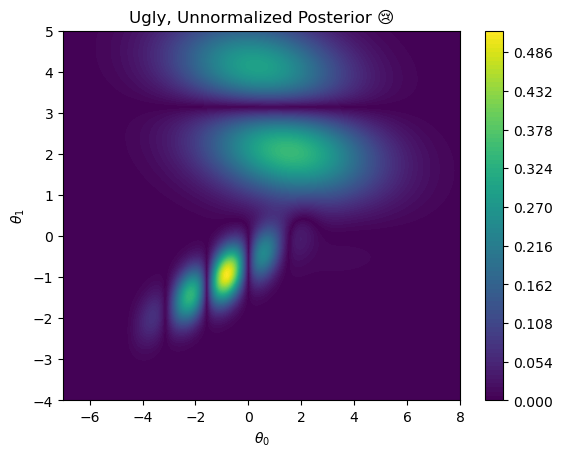

In [66]:
theta1_range = (-7,8)
theta2_range = (-4,5)
t1 = np.linspace(*theta1_range, 200)
t2 = np.linspace(*theta2_range, 200)
tt1, tt2 = np.meshgrid(t1, t2)
thetas_space = np.hstack((tt1.reshape(-1,1), tt2.reshape(-1,1)))
posterior_space = posterior(thetas_space)

plt.contourf(tt1, tt2, posterior_space.reshape(200,200), levels=100)
plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title("Ugly, Unnormalized Posterior 😢");

In [67]:
def proposal_sample(sigma=0.75):
    return np.random.multivariate_normal((0,0),[[sigma,0],[0,sigma]])

In [68]:
%%time
np.random.seed(109)
# number of separate chains to run
chains = 2
# total samples to keep make
draws = 10000
# number of early samples to 'throw away'
tune = 10000
samples = np.zeros((chains, tune+draws, 2))
for c in range(chains):
    # initialize theta
    theta = np.array([np.random.uniform(-3,5), np.random.uniform(-3,5)])
    for i in range(tune+draws):
        delta = proposal_sample()
        proposed_sample = theta + delta 
        U = np.random.uniform(0,1)
        alpha = np.min([1, (posterior(proposed_sample)/posterior(theta))])
        if U <= alpha:
            theta = proposed_sample
        samples[c,i] = theta

CPU times: user 30.9 s, sys: 12 ms, total: 30.9 s
Wall time: 30.9 s


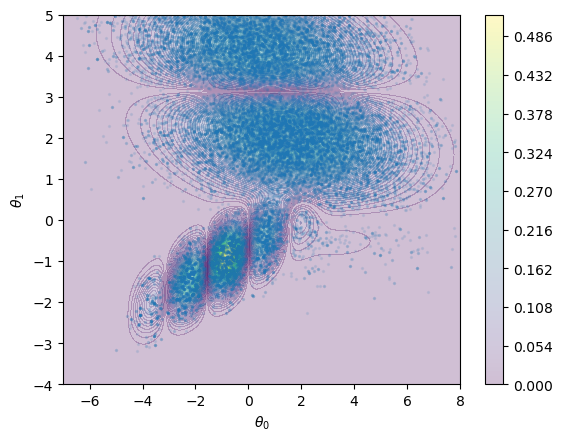

In [80]:
plt.contourf(tt1, tt2, posterior_space.reshape(200,200), alpha=0.25, levels=100)
plt.xlim(*theta1_range)
plt.ylim(*theta2_range)
plt.colorbar()
plt.scatter(*np.array(samples[:tune]).T, alpha=0.1, s=2)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$');

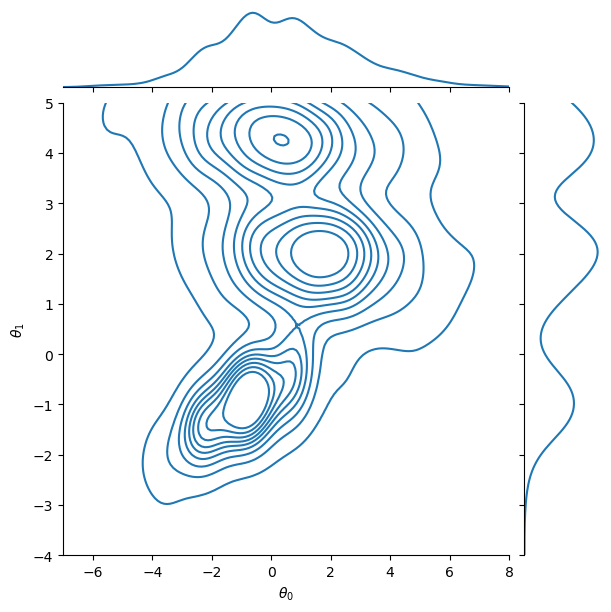

In [70]:
joint = sns.jointplot(x=samples[0,:tune,0], y=samples[0,:tune,1], kind='kde')
joint.set_axis_labels(r'$\theta_0$', r'$\theta_1$');
plt.xlim(*theta1_range)
plt.ylim(*theta2_range);

In [71]:
# keep only samples after tune aka 'burn in' period
thetas = samples[:,tune:]

In [72]:
samples.shape, tune, draws, thetas.shape

((2, 20000, 2), 10000, 10000, (2, 10000, 2))

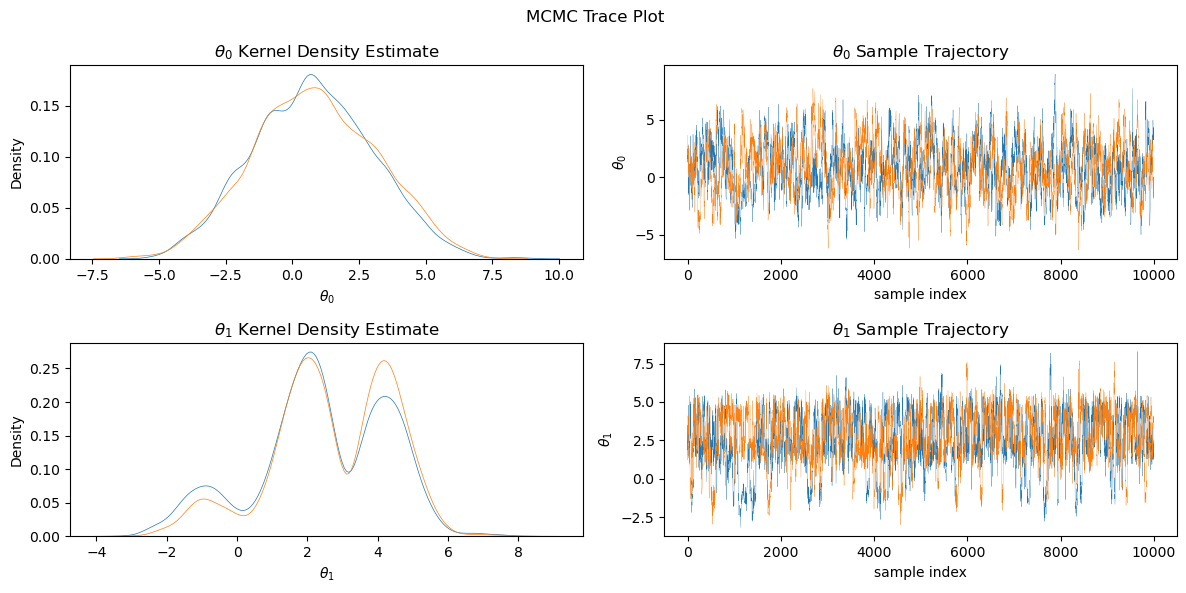

In [73]:
# plot trace
fig, axs = plt.subplots(2,2, figsize=(12,6))
for i, param in enumerate([r'$\theta_0$', r'$\theta_1$']):
    for c in range(chains):
        sns.kdeplot(x=thetas[c,:,i], lw=0.5, ax=axs[i,0])
        axs[i,1].plot(thetas[c,:,i], lw=0.2)
    axs[i,0].set_title(f'{param} Kernel Density Estimate')
    axs[i,0].set_xlabel(f'{param}')
    axs[i,1].set_title(f'{param} Sample Trajectory')
    axs[i,1].set_ylabel(f'{param}')
    axs[i,1].set_xlabel("sample index")
plt.suptitle("MCMC Trace Plot")
plt.tight_layout()

In [74]:
# ref: https://pymcmc.readthedocs.io/en/latest/modelchecking.html#convergence-diagnostics
def r_hat(thetas):
    m = thetas.shape[0] # number of chains
    n = thetas.shape[1] # num samples
    B = (n/(m-1))*2*((thetas[0].mean() - thetas[1].mean())**2)
    W = sum([np.var(thetas[i]) for i in range(m)])/m
    var_theta_y = ((n-1)/n)*W+(1/n)*B
    return np.sqrt(var_theta_y/W)

In [75]:
summary = []
for i in range(thetas.shape[-1]):
    results = {'mean': thetas[:,:,i].mean(),
               'std': thetas[:,:,i].std(),
               '2.5_percentile': np.percentile(thetas[:,:,i], 2.5),
               '97.5_percentile': np.percentile(thetas[:,:,i], 97.5),
               'r_hat': r_hat(thetas[:,:,i])
               }
    summary.append(results)
pd.DataFrame(summary, index=[r"$\theta_0$", r"$\theta_1$"])

,mean,std,2.5_percentile,97.5_percentile,r_hat
$\theta_0$,0.825811,2.284060,-3.545549,5.233644,1.001229
$\theta_1$,2.558603,1.830418,-1.458506,5.361309,1.026162
